# Project : Fake Tweets with Avg-W2v & stopwords

In [1]:
# importing the libaries

import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score , KFold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report , confusion_matrix , f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix , roc_curve , accuracy_score , precision_score , recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB , GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string
import nltk

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

import folium 
from folium import plugins

from spellchecker import SpellChecker

Using TensorFlow backend.


In [2]:
# Load the train and test dataset

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

In [3]:
train.shape

(7613, 5)

In [4]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [6]:
new_train = train
new_train['keyword'].fillna("No keyword",inplace=True)
new_train.isnull().sum()

id             0
keyword        0
location    2533
text           0
target         0
dtype: int64

In [7]:
# drop the location column both from train and test part

# train.drop(['location'] , axis = 1 , inplace = True)
# test.drop(['location'] , axis = 1 , inplace = True)

In [8]:
train.shape

(7613, 5)

## EDA

Text(0, 0.5, 'Number of samples')

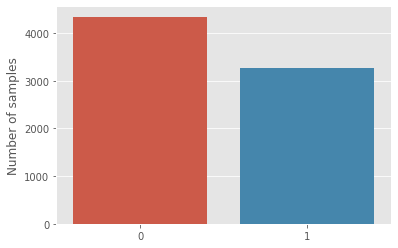

In [10]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('Number of samples')

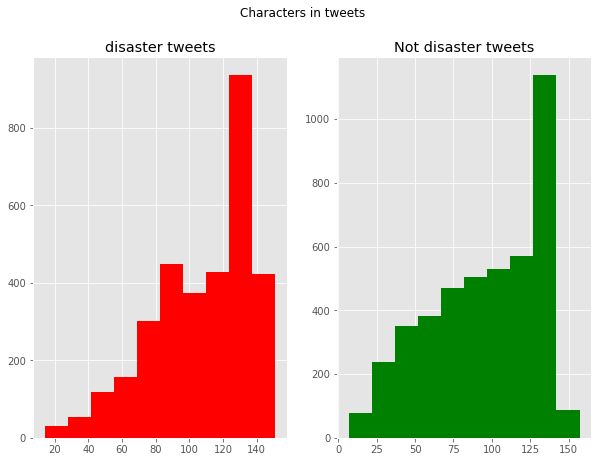

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

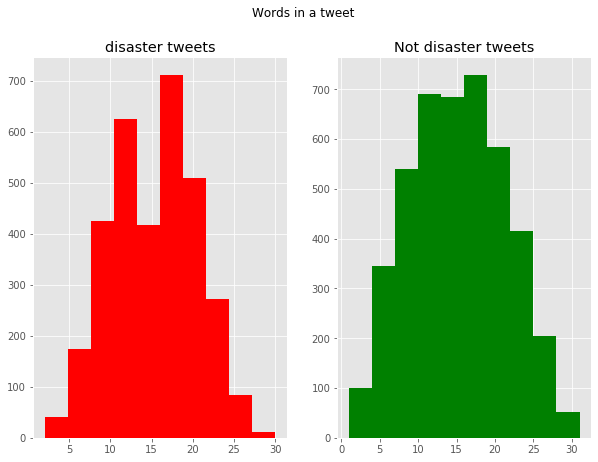

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

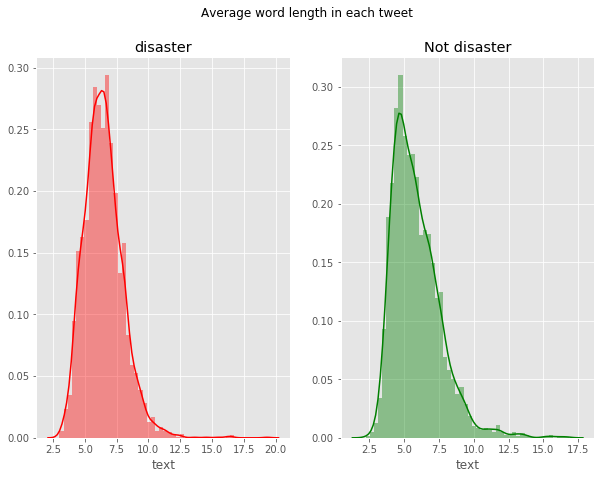

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [14]:
# Tweets per location

cnt_ = train['location'].value_counts()
cnt_.reset_index()
cnt_ = cnt_[:20,]
trace1 = go.Bar(
                x = cnt_.index,
                y = cnt_.values,
                name = "Number of tweets in dataset according to location",
                marker = dict(color = 'rgba(200, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )

data = [trace1]
layout = go.Layout(barmode = "group",title = 'Number of tweets depending on location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [14]:
#Number of tweets depending on location per class

train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]
cnt_1 = train1_df['location'].value_counts()
cnt_1.reset_index()
cnt_1 = cnt_1[:20,]

cnt_0 = train0_df['location'].value_counts()
cnt_0.reset_index()
cnt_0 = cnt_0[:20,]

trace1 = go.Bar(
                x = cnt_1.index,
                y = cnt_1.values,
                name = "Number of real disaster tweets",
                marker = dict(color = 'rgba(255, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )
trace0 = go.Bar(
                x = cnt_0.index,
                y = cnt_0.values,
                name = "Number of unreal disaster tweets",
                marker = dict(color = 'rgba(79, 82, 97, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )


data = [trace0,trace1]
layout = go.Layout(barmode = 'stack',title = 'Number of tweets depending on location per class')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

#### Visualize per location using map

In [15]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


df = train['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="specify_your_app_name_here")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}
for i in df['location'].values:
    print(i)
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude
df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

USA
New York
United States
London
Canada
Nigeria
UK
Los Angeles, CA
India
Mumbai
Washington, DC
Kenya
Worldwide
Australia
Chicago, IL
California
Everywhere
New York, NY
California, USA
San Francisco


In [16]:
map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
markers = []
for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)
map1

It is clear that most of the tweets from america region.

#### Common Stopwords in tweets

In [17]:
def create_corpus(target):
    corpus =[]
    
    for x in train[train['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
            
    return corpus

In [18]:
corpus = create_corpus(1)

In [19]:
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top = sorted(dic.items(), key = lambda x:x[1] , reverse = True)[:10] 

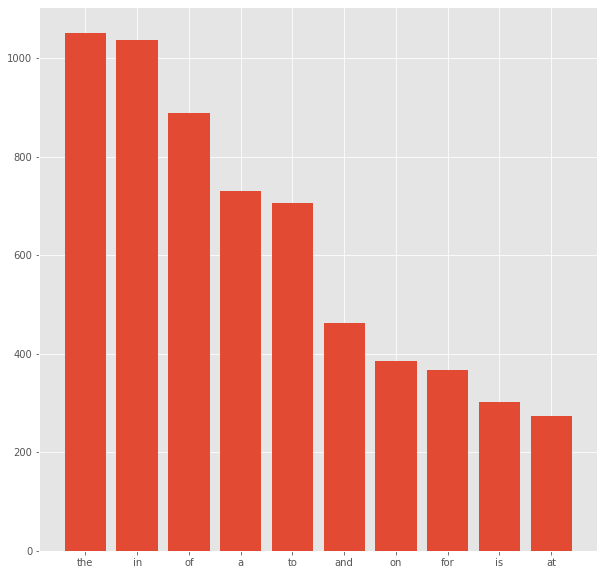

In [20]:
x , y = zip(*top)
plt.figure(figsize = (10 , 10))
plt.bar(x , y);

#### Analyzing Punctuations

<BarContainer object of 18 artists>

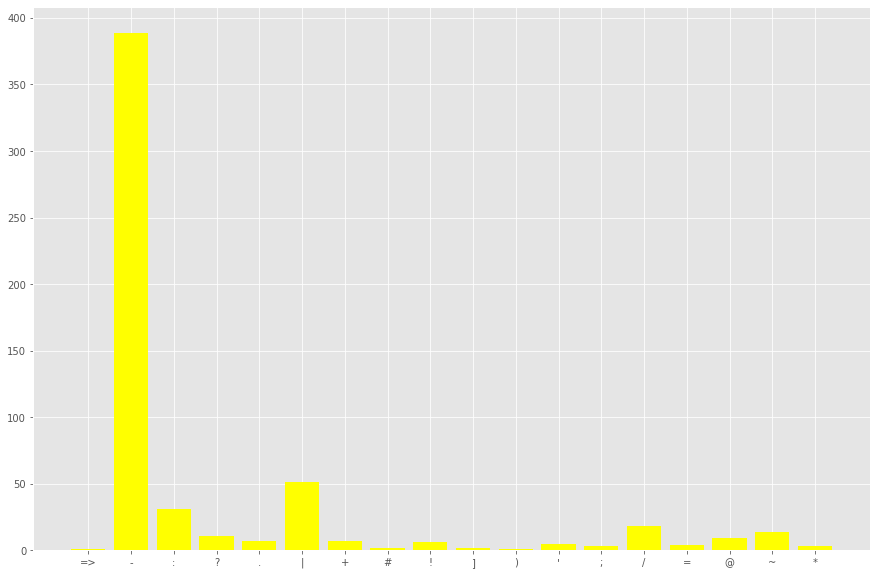

In [21]:
plt.figure(figsize=(15 , 10))

corpus = create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y , color = 'yellow')

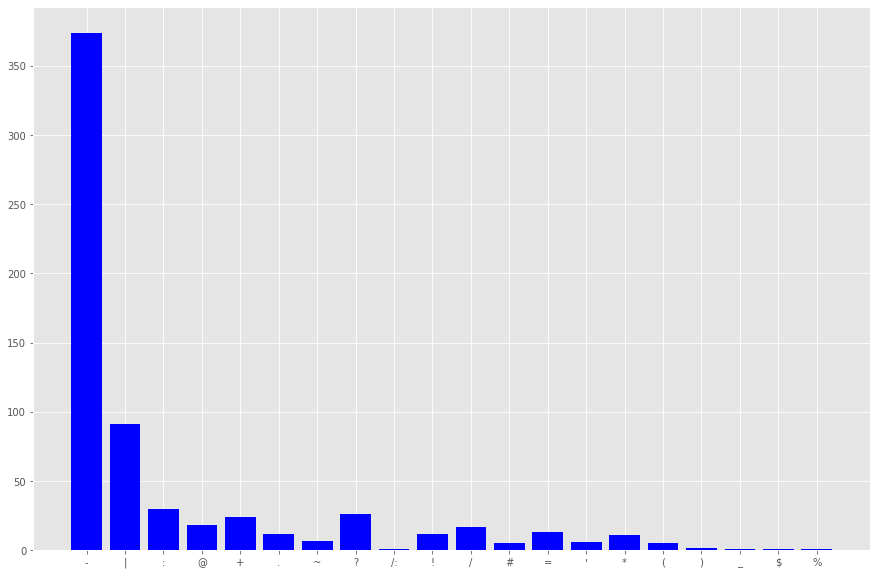

In [22]:
plt.figure(figsize=(15 , 10))
corpus = create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x , y , color = 'blue');

#### Common Words

In [23]:
counter=Counter(corpus)
most=counter.most_common()

x=[]
y=[]

for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

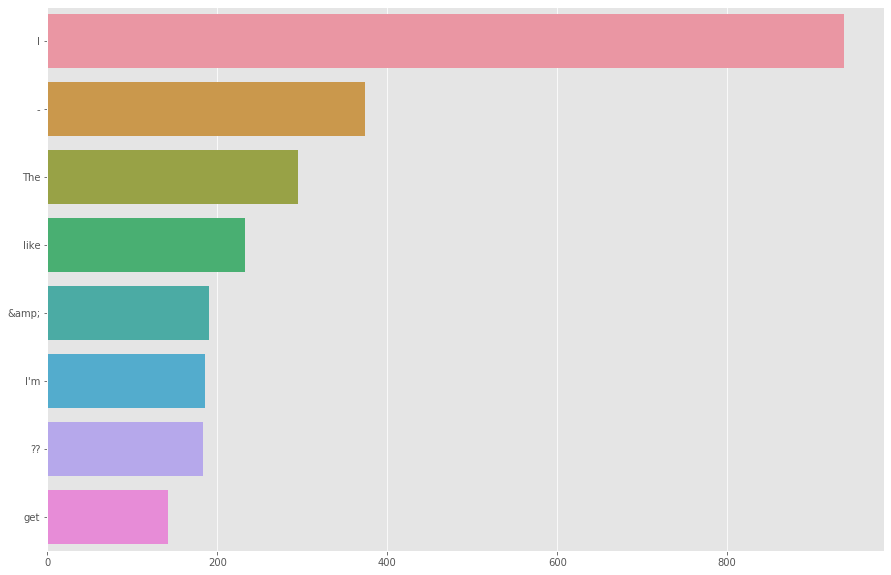

In [24]:
plt.figure(figsize=(15 , 10))
sns.barplot(x = y , y = x);

In [9]:
df = pd.concat([train , test])

## Data Preprocessing

1 . Removing stop words

2 . Remove Punctuations

3 . Remove Html

4 . Remove Emojis

5 . Spelling Corrections

6 . Removing Urls

In [10]:
## Concate both train and test part
df_new = pd.concat([train , test])

In [11]:
df_new.shape

(10876, 5)

In [12]:
df_new.isnull().sum()

id             0
keyword       26
location    3638
text           0
target      3263
dtype: int64

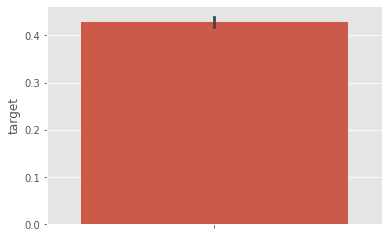

In [13]:
sns.barplot(y = 'target' , data = df_new)

In [14]:
df_new.head(20)

,id,keyword,location,text,target
0,1,No keyword,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,No keyword,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,No keyword,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,No keyword,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,No keyword,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0
5,8,No keyword,NaN,#RockyFire Update => California Hwy. 20 closed...,1.0
6,10,No keyword,NaN,#flood #disaster Heavy rain causes flash flood...,1.0
7,13,No keyword,NaN,I'm on top of the hill and I can see a fire in...,1.0
8,14,No keyword,NaN,There's an emergency evacuation happening now ...,1.0
9,15,No keyword,NaN,I'm afraid that the tornado is coming to our a...,1.0


In [15]:
df_new.tail()

,id,keyword,location,text,target
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


In [16]:
df_new['text'][0]

0    Our Deeds are the Reason of this #earthquake M...
0                   Just happened a terrible car crash
Name: text, dtype: object

In [17]:
df_new['text'][12]

12    #raining #flooding #Florida #TampaBay #Tampa 1...
12                               No don't tell me that!
Name: text, dtype: object

In [18]:
train['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

### Removing Stopwords

In [19]:
stop_words = set(stopwords.words('english'))

In [20]:
def data_text_preprocessing(all_text , ind , col):
    if type(all_text) is not int:
        
        string = ""
    
        all_text = all_text.lower()
        
        all_text = ''.join([i for i in all_text if not i.isdigit()]) 

        for word in all_text.split():
            if not word in stop_words:
                string +=word + " "

        train[col][ind] = string

In [21]:
for index , row in train.iterrows():
    if type(row['text']) is str:
        data_text_preprocessing(row['text'] , index , 'text')

In [22]:
def data_text_preprocessing(all_text , ind , col):
    if type(all_text) is not int:
        
        string = ""
             
        all_text = all_text.lower()
        
        all_text = ''.join([i for i in all_text if not i.isdigit()])

        for word in all_text.split():
            if not word in stop_words:
                string +=word + " "

        test[col][ind] = string

In [23]:
for index , row in test.iterrows():
    if type(row['text']) is str:
        data_text_preprocessing(row['text'] , index , 'text')

In [24]:
train.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,deeds reason #earthquake may allah forgive us,1
1,4,No keyword,NaN,forest fire near la ronge sask. canada,1
2,5,No keyword,NaN,residents asked 'shelter place' notified offic...,1
3,6,No keyword,NaN,", people receive #wildfires evacuation orders ...",1
4,7,No keyword,NaN,got sent photo ruby #alaska smoke #wildfires p...,1


In [25]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,"heard #earthquake different cities, stay safe ..."
2,3,NaN,NaN,"forest fire spot pond, geese fleeing across st..."
3,9,NaN,NaN,apocalypse lighting. #spokane #wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan


### Removing URLS

In [26]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [27]:
train['text'] = train['text'].apply(lambda x : remove_URL(x))
df_new['text'] = df_new['text'].apply(lambda x : remove_URL(x))

### Remove HTML tags

In [28]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [29]:
train['text'] = train['text'].apply(lambda x : remove_html(x))
df_new['text'] = df_new['text'].apply(lambda x : remove_URL(x))

### Remove Emoji's

In [30]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [31]:
df_new['text']=df_new['text'].apply(lambda x: remove_emoji(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))

In [32]:
df_new['text'][12]

12    #raining #flooding #Florida #TampaBay #Tampa 1...
12                               No don't tell me that!
Name: text, dtype: object

### Remove Punctuations

In [33]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [34]:
df_new['text'] = df_new['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))

In [35]:
df_new['text'][12]

12    raining flooding Florida TampaBay Tampa 18 or ...
12                                 No dont tell me that
Name: text, dtype: object

In [36]:
train['text'][12]

'raining flooding florida tampabay tampa days ive lost count '

In [37]:
train.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,deeds reason earthquake may allah forgive us,1
1,4,No keyword,NaN,forest fire near la ronge sask canada,1
2,5,No keyword,NaN,residents asked shelter place notified officer...,1
3,6,No keyword,NaN,people receive wildfires evacuation orders ca...,1
4,7,No keyword,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [38]:
train.tail()

,id,keyword,location,text,target
7608,10869,No keyword,NaN,two giant cranes holding bridge collapse nearb...,1
7609,10870,No keyword,NaN,ariaahrary thetawniest control wild fires cali...,1
7610,10871,No keyword,NaN,m utckm volcano hawaii,1
7611,10872,No keyword,NaN,police investigating ebike collided car little...,1
7612,10873,No keyword,NaN,latest homes razed northern california wildfir...,1


### Spelling corrections

In [39]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [40]:
# df_new['text'] = df_new['text'].apply(lambda x : correct_spellings(x))
# train['text'] = train['text'].apply(lambda x : correct_spellings(x))

In [41]:
train.tail()

,id,keyword,location,text,target
7608,10869,No keyword,NaN,two giant cranes holding bridge collapse nearb...,1
7609,10870,No keyword,NaN,ariaahrary thetawniest control wild fires cali...,1
7610,10871,No keyword,NaN,m utckm volcano hawaii,1
7611,10872,No keyword,NaN,police investigating ebike collided car little...,1
7612,10873,No keyword,NaN,latest homes razed northern california wildfir...,1


In [42]:
df_new.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0
1,4,No keyword,NaN,Forest fire near La Ronge Sask Canada,1.0
2,5,No keyword,NaN,All residents asked to shelter in place are be...,1.0
3,6,No keyword,NaN,13000 people receive wildfires evacuation orde...,1.0
4,7,No keyword,NaN,Just got sent this photo from Ruby Alaska as s...,1.0


## Convert Text to AVG-W2V

In [43]:
x = train.drop(['keyword' , 'location' , 'target'] , axis = 1)
y = train['target']

In [44]:
x

,id,text
0,1,deeds reason earthquake may allah forgive us
1,4,forest fire near la ronge sask canada
2,5,residents asked shelter place notified officer...
3,6,people receive wildfires evacuation orders ca...
4,7,got sent photo ruby alaska smoke wildfires pou...
...,...,...
7608,10869,two giant cranes holding bridge collapse nearb...
7609,10870,ariaahrary thetawniest control wild fires cali...
7610,10871,m utckm volcano hawaii
7611,10872,police investigating ebike collided car little...


In [45]:
test

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,"heard #earthquake different cities, stay safe ..."
2,3,NaN,NaN,"forest fire spot pond, geese fleeing across st..."
3,9,NaN,NaN,apocalypse lighting. #spokane #wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan
...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles ûò safety faste...
3259,10865,NaN,NaN,storm ri worse last hurricane. city&amp;others...
3260,10868,NaN,NaN,green line derailment chicago http://t.co/utbx...
3261,10874,NaN,NaN,meg issues hazardous weather outlook (hwo) htt...


In [46]:
final_test = test.drop(['keyword' , 'location'] , axis = 1)
final_test

,id,text
0,0,happened terrible car crash
1,2,"heard #earthquake different cities, stay safe ..."
2,3,"forest fire spot pond, geese fleeing across st..."
3,9,apocalypse lighting. #spokane #wildfires
4,11,typhoon soudelor kills china taiwan
...,...,...
3258,10861,earthquake safety los angeles ûò safety faste...
3259,10865,storm ri worse last hurricane. city&amp;others...
3260,10868,green line derailment chicago http://t.co/utbx...
3261,10874,meg issues hazardous weather outlook (hwo) htt...


In [47]:
final_test.shape

(3263, 2)

In [48]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.20 , random_state = 78)

In [49]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(6090, 2)
(1523, 2)
(6090,)


### W2V on Text


In [66]:
w2v_model = gensim.models.Word2Vec(x_train['text'])

In [67]:
w2v_words = list(w2v_model.wv.vocab)
print(len(w2v_words))

42


### Without using library

In [82]:
# X_Train

import gensim
i=0
list_of_sent_x_train=[]
for sent in tqdm(x_train['text'].values):
    filtered_sentence=[]
    sent = remove_html(sent)
    for w in sent.split():
        for cleaned_words in remove_punct(w).split():
            if(cleaned_words.isalpha()):   
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_x_train.append(filtered_sentence)

100%|██████████| 6090/6090 [00:00<00:00, 21501.09it/s]


In [83]:
w2v_model = gensim.models.Word2Vec(list_of_sent_x_train)

In [77]:
w2v_words = list(w2v_model.wv.vocab)
print(len(w2v_words))

2209


In [86]:
# Convert x_train_w2v to avg-w2v

sent_vectors_x_train = []; 

for sent in tqdm(list_of_sent_x_train):
    sent_vec = np.zeros(100) 
    cnt_words = 0 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_x_train.append(sent_vec) 

print(len(sent_vectors_x_train))
print(len(sent_vectors_x_train[0]))

100%|██████████| 6090/6090 [00:01<00:00, 3486.38it/s]

6090
100


In [81]:
a = sent_vectors_x_train
a = pd.DataFrame(a)
a

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.021294,-0.024903,-0.012519,0.029349,0.011157,-0.034700,0.006896,0.000198,-0.003499,-0.026365,...,0.004522,-0.012347,-0.050434,0.055750,-0.013876,0.032780,0.016859,0.018673,-0.035483,0.004300
1,-0.036489,-0.039465,-0.016749,0.051864,0.016967,-0.056230,0.008197,-0.001112,-0.006422,-0.042282,...,0.006631,-0.018517,-0.077269,0.087716,-0.020212,0.049291,0.030368,0.031702,-0.056155,0.005538
2,-0.041682,-0.044557,-0.018066,0.056203,0.018934,-0.061944,0.008685,-0.003652,-0.004787,-0.051502,...,0.005251,-0.022494,-0.091902,0.096007,-0.021288,0.059662,0.032088,0.030220,-0.062350,0.004504
3,-0.044836,-0.057357,-0.022906,0.067292,0.022795,-0.074257,0.008031,-0.001772,-0.008851,-0.058403,...,0.008063,-0.029760,-0.102611,0.116234,-0.026450,0.071995,0.039169,0.038058,-0.079156,0.005305
4,-0.064777,-0.077139,-0.031097,0.096077,0.032565,-0.104845,0.015337,-0.003563,-0.011134,-0.078664,...,0.011482,-0.036801,-0.150341,0.167155,-0.034630,0.102183,0.053340,0.054233,-0.107086,0.008096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6085,-0.066628,-0.077716,-0.031860,0.098200,0.033017,-0.105631,0.016294,-0.003558,-0.012626,-0.081079,...,0.012541,-0.037539,-0.153620,0.166613,-0.036441,0.099032,0.055237,0.054658,-0.107530,0.007082
6086,-0.029501,-0.032425,-0.014000,0.039089,0.012029,-0.040699,0.003666,-0.003265,-0.003450,-0.031313,...,0.005174,-0.013748,-0.059928,0.067922,-0.014219,0.038509,0.019939,0.020021,-0.043116,0.006747
6087,-0.016143,-0.017109,-0.005262,0.021259,0.008176,-0.021862,0.004296,0.001151,-0.002202,-0.017985,...,0.002941,-0.009272,-0.034371,0.035239,-0.006421,0.020535,0.011819,0.011023,-0.022499,0.002490
6088,-0.058743,-0.068038,-0.027762,0.080923,0.028815,-0.091935,0.012508,-0.002698,-0.009365,-0.070327,...,0.011050,-0.032331,-0.132024,0.144778,-0.033927,0.086920,0.047098,0.048167,-0.096609,0.007170


In [88]:
# X_test

import gensim
i=0
list_of_sent_x_test = []
for sent in tqdm(x_test['text'].values):
    filtered_sentence=[]
    sent=remove_html(sent)
    for w in sent.split():
        for cleaned_words in remove_punct(w).split():
            if(cleaned_words.isalpha()):   
                filtered_sentence.append(cleaned_words.lower()) 
            else:
                continue 
    list_of_sent_x_test.append(filtered_sentence)

100%|██████████| 1523/1523 [00:00<00:00, 20625.30it/s]


In [89]:
# w2v_model = gensim.models.Word2Vec(list_of_sent_x_test)
# w2v_model_test = list(w2v_model.wv.vocab)
# print(len(w2v_words))

In [90]:
# Convert x_test_w2v to avg-w2v

sent_vectors_x_test = []; 

for sent in tqdm(list_of_sent_x_test):
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_x_test.append(sent_vec) 

print(len(sent_vectors_x_test))
print(len(sent_vectors_x_test[0]))

100%|██████████| 1523/1523 [00:00<00:00, 3470.62it/s]

1523
100


In [91]:
# Test

import gensim
i=0

list_of_sent_test=[]
for sent in tqdm(test['text'].values):
    filtered_sentence=[]
    sent=remove_html(sent)
    for w in sent.split():
        for cleaned_words in remove_punct(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

100%|██████████| 3263/3263 [00:00<00:00, 20195.81it/s]


In [92]:
# w2v_model = gensim.models.Word2Vec(list_of_sent_x_test)
# w2v_model_Test = list(w2v_model.wv.vocab)
# print(len(w2v_words))

In [93]:
# Convert test_w2v to avg-w2v

sent_vectors_test = []; 
for sent in tqdm(list_of_sent_test):
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec) 
    
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 3263/3263 [00:01<00:00, 3173.39it/s]

3263
100


In [94]:
x_train_w2v = sent_vectors_x_train
x_test_w2v = sent_vectors_x_test
test_w2v = sent_vectors_test

In [95]:
len(test_w2v)

3263

## Apply DIfferent ML model on AVG-W2V

## Logistic Regression on AVG-W2V

In [97]:
#Standardising the train and test data

#sc = StandardScaler(copy = True , with_mean = False , with_std = True)
sc = StandardScaler()
X_train = sc.fit_transform(x_train_w2v)
X_test = sc.transform(x_test_w2v)
Test = sc.transform(test_w2v)

In [98]:
tuned_parameters = [10**-4, 10**-2, 10**0, 10**2, 10**4]

cv_scores = []

for i in tqdm(tuned_parameters):
    model = LogisticRegression(penalty = 'l1' , C = i , n_jobs = -1)
    scores = cross_val_score(model , X_train , y_train , cv = 10 , scoring = 'accuracy' , n_jobs = -1)
    cv_scores.append(scores.mean())

100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


In [99]:
optimal_C = tuned_parameters[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of C is %.3f.' % optimal_C)


The optimal value of C is 0.000.


In [102]:
lr = LogisticRegression(penalty = 'l2' , C = 0.0001 , n_jobs = -1)
lr.fit(X_train , y_train)
pred = lr.predict(X_test)

ac = accuracy_score(y_test , pred)
print(ac*100)

58.896913985554825


***Test Data Report***
Best C =  0.0001
AUC =  50.96724280539631


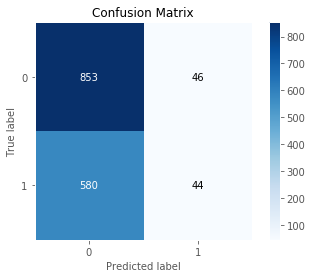

In [104]:
from sklearn import metrics
import scikitplot as skplt

print("***Test Data Report***")
print("Best C = ",optimal_C)
fpr, tpr, threshold = roc_curve(y_test , lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [114]:
fpr, tpr, threshold = metrics.roc_curve(y_test , lr.predict(X_test))
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test , lr.predict(X_test))

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

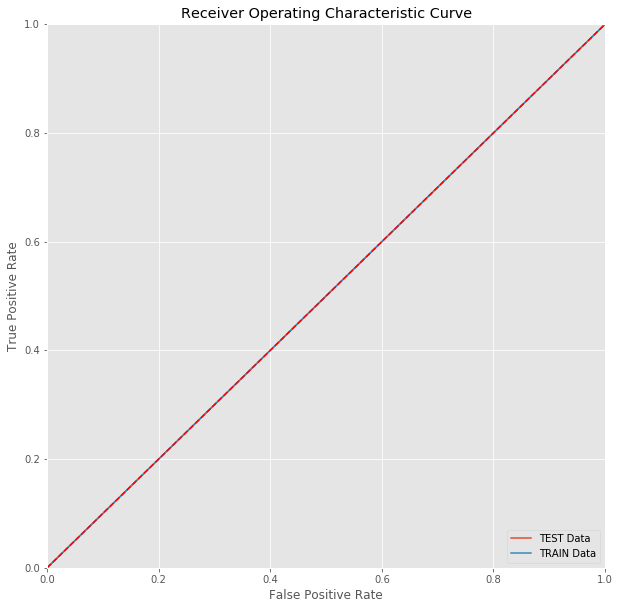

In [115]:
# plot ROC-curve
plt.figure(figsize = (10 , 10))
plt.title('Receiver Operating Characteristic Curve')
plt.gca()
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [76]:
# feature_name = sent_vectors_x_train.get_feature_names()
# w = lr.coef_
# weight=w.reshape(-1)
# sorted_feature = np.argsort(weight)
# top_20_positive_feature=sorted_feature[:-20:-1]

In [78]:
# print("Positive feature top 20 :")
# print("-------")
# for i in top_20_positive_feature:
#     print("%s\t-->\t%f"%(feature_name[i],weight[i]))

In [80]:
# w = lr.coef_
# weight=w.reshape(-1)
# sorted_feature = np.argsort(weight)
# feature_name = count_vect.get_feature_names()
# top_20_negative_feature = sorted_feature[:20]

In [81]:
# print("Negative feature top 20 :")
# print("-------")
# for i in top_20_negative_feature:
#     print("%s\t -->\t%f  "%(feature_name[i],weight[i]))

In the above list it is clear that there are so many stop words that affects our model.we have to remove the stopwords.

In [134]:
lr = LogisticRegression(penalty = 'l2' , C = 0.0001 , n_jobs = -1)
lr.fit(X_train , y_train)
pred = lr.predict(X_test)

ac = accuracy_score(y_test , pred)
print(ac*100)

59.487852921864736


## Apply KNN on AVG-W2V

In [117]:
knn = KNeighborsClassifier()
knn.fit(X_train , y_train)

y_pred_knn = knn.predict(X_test)

ac = accuracy_score(y_test , y_pred_knn)
print(ac*100)

41.2344057780696


In [75]:
n_folds = 5
parameters = {
        'n_neighbors': range (2 , 50 , 2)
        }


In [76]:
knn = KNeighborsClassifier()

tree = GridSearchCV(estimator = knn , param_grid = parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)
tree.fit(X_train , y_train)

score1 = tree.cv_results_

print(pd.DataFrame(score1).head())
print(tree.best_params_)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.004988      0.000631         0.533524        0.009570   
1       0.004796      0.000750         0.645834        0.046200   
2       0.005581      0.000799         0.577961        0.018822   
3       0.009375      0.007291         0.574671        0.039541   
4       0.007781      0.003301         0.679563        0.171710   

  param_n_neighbors               params  split0_test_score  \
0                 2   {'n_neighbors': 2}           0.666667   
1                 4   {'n_neighbors': 4}           0.639573   
2                 6   {'n_neighbors': 6}           0.639573   
3                 8   {'n_neighbors': 8}           0.621511   
4                10  {'n_neighbors': 10}           0.613300   

   split1_test_score  split2_test_score  split3_test_score  ...  \
0           0.647783           0.638752           0.653530  ...   
1           0.647783           0.615764           0.643678  ...   
2           0.637

In [77]:
score1 = pd.DataFrame(score1)
score1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.004988,0.000631,0.533524,0.009570,2,{'n_neighbors': 2},0.666667,0.647783,0.638752,0.653530,...,0.650082,0.009608,1,0.717159,0.728243,0.726806,0.722496,0.718801,0.722701,0.004325
1,0.004796,0.000750,0.645834,0.046200,4,{'n_neighbors': 4},0.639573,0.647783,0.615764,0.643678,...,0.633990,0.012369,2,0.649836,0.712849,0.659278,0.656199,0.658251,0.667282,0.023018
2,0.005581,0.000799,0.577961,0.018822,6,{'n_neighbors': 6},0.639573,0.637110,0.615764,0.641215,...,0.629392,0.012228,3,0.646757,0.661125,0.653941,0.651683,0.631773,0.649056,0.009802
3,0.009375,0.007291,0.574671,0.039541,8,{'n_neighbors': 8},0.621511,0.636289,0.609195,0.624795,...,0.620361,0.010063,4,0.628284,0.659688,0.635263,0.628489,0.623768,0.635099,0.012831
4,0.007781,0.003301,0.679563,0.171710,10,{'n_neighbors': 10},0.613300,0.623153,0.605911,0.619048,...,0.614286,0.006175,5,0.616174,0.634647,0.624179,0.622126,0.621716,0.623768,0.006051


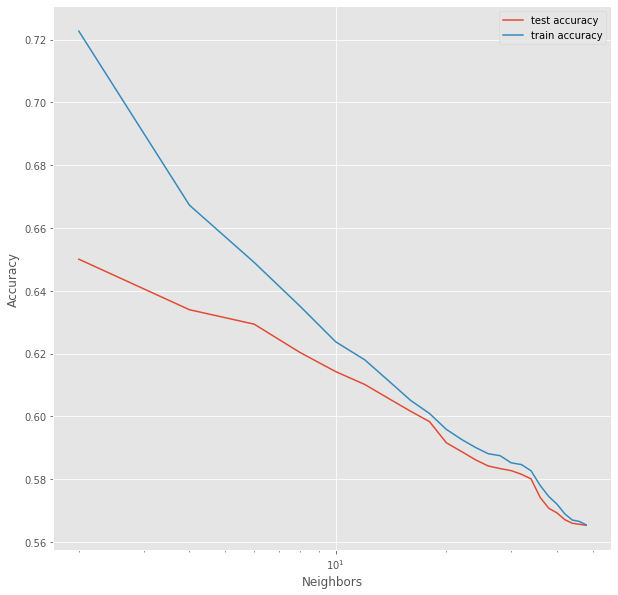

In [78]:
plt.figure(figsize=(10 , 10))
plt.plot(score1['param_n_neighbors'], score1['mean_test_score'])
plt.plot(score1['param_n_neighbors'], score1['mean_train_score'])
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'] , loc='upper right')
plt.xscale('log')

In [135]:
knn = KNeighborsClassifier(n_neighbors = 12 , algorithm = 'kd_tree')
knn.fit(X_train , y_train)

y_pred_knn = knn.predict(X_test)

ac_knn = accuracy_score(y_test , y_pred_knn)
print('After Cross-validation: ',ac*100)

After Cross-validation:  59.487852921864736


## Naive-Bayes on AVG-W2V

In [81]:
alpha = [] 
i = 0.001

while(i <= 1000):
    alpha.append(np.round(i,3))
    i *= 3

cv_scores = []

for k in tqdm(alpha):
    model = MultinomialNB(alpha = k)
    scores = cross_val_score(model , X_train , y_train , cv = 10 , scoring = 'f1_macro' , n_jobs = -1)
    cv_scores.append(scores.mean()) 

100%|██████████| 13/13 [00:01<00:00,  8.46it/s]


In [83]:
optimal_alpha = alpha[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 531.441.


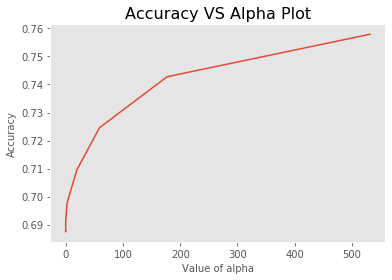


*******Train Data Report******

Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

F1 Score for each value of alpha :
  [68.768 68.738 68.847 68.97  69.038 69.162 69.276 69.746 70.057 70.958
 72.456 74.277 75.793]


In [84]:
# plot accuracy vs alpha 
plt.plot(alpha, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha Plot',size=16)
plt.grid()
plt.show()
print("\n*******Train Data Report******");
print("\nAlpha values :\n",alpha)
print("\nF1 Score for each value of alpha :\n ", np.round(cv_scores,5)*100)

In [85]:
model_bow_multinomial = MultinomialNB(alpha = optimal_alpha)

model_bow_multinomial.fit(X_train , y_train)

pred = model_bow_multinomial.predict(X_test)

***Test Data Report***
Accuracy =  79.51411687458962
f1_score =  78.47256200324016
precision_score =  79.13218556563797
recall_score =  78.08836741678789


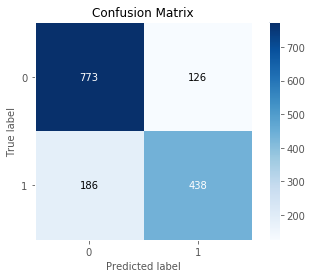

In [89]:
print("***Test Data Report***")
print('Accuracy = ', accuracy_score(y_test, pred)*100)
print("f1_score = ",f1_score(y_test, pred, average='macro')*100)

print("precision_score = " , precision_score(y_test , pred, average='macro')*100)
print("recall_score = " , recall_score(y_test, pred, average='macro')*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)

plt.show()

In [91]:
print(classification_report(y_test , pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       899
           1       0.78      0.70      0.74       624

    accuracy                           0.80      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.80      0.79      1523



## SVM on AVG-W2V

In [136]:
sv = SVC()
sv.fit(X_train , y_train)

y_pred_svm = sv.predict(X_test)

ac_svr = accuracy_score(y_test , y_pred_svm)
print(ac_svr*100)

75.64018384766908


In [94]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
params = {"C": [0.01 , 0.1, 1, 10, 100, 1000]}

model = SVC()

model_cv_C = GridSearchCV(estimator = model, param_grid = params, cv = folds , verbose = 1 , return_train_score=True , n_jobs = -1)
model_cv_C.fit(X_train, y_train) 


cv_results = pd.DataFrame(model_cv_C.cv_results_)
cv_results

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.4min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,10.318077,0.154108,2.092425,0.150773,0.01,{'C': 0.01},0.581281,0.536946,0.574713,0.591133,...,0.565353,0.021570,5,0.561371,0.572455,0.563013,0.558908,0.571018,0.565353,0.005393
1,8.707073,0.506377,1.864736,0.101443,0.1,{'C': 0.1},0.581281,0.536946,0.574713,0.591133,...,0.565353,0.021570,5,0.561371,0.572455,0.563013,0.558908,0.571018,0.565353,0.005393
2,8.150981,0.161615,2.023904,0.075840,1,{'C': 1},0.728243,0.684729,0.733990,0.729064,...,0.712479,0.022082,4,0.969417,0.967980,0.968801,0.967159,0.967159,0.968103,0.000896
3,9.221630,0.423916,2.007184,0.148073,10,{'C': 10},0.744663,0.727422,0.784072,0.771757,...,0.754351,0.020571,1,0.989943,0.989943,0.989327,0.987274,0.988506,0.988998,0.001011
4,9.154882,0.449905,1.517774,0.054401,100,{'C': 100},0.738095,0.722496,0.775862,0.759442,...,0.745320,0.019591,2,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750
5,7.713616,0.630339,1.490521,0.087230,1000,{'C': 1000},0.740558,0.720033,0.772578,0.757800,...,0.744992,0.018378,3,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750


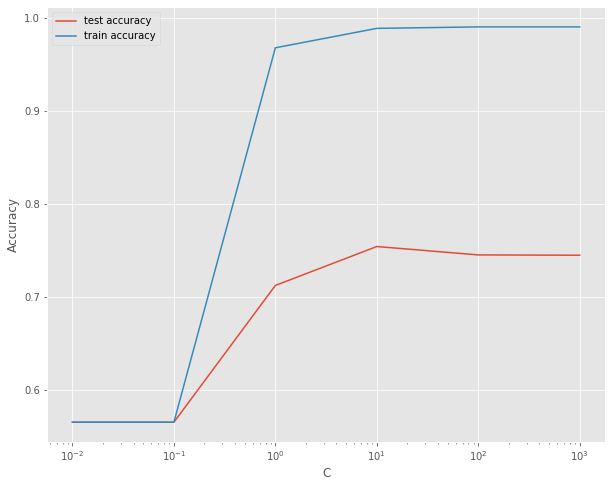

In [95]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [96]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
gamma = {'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

model = SVC()

model_cv_g = GridSearchCV(estimator = model, param_grid = gamma, cv = folds , verbose = 1 , return_train_score=True ,  n_jobs = -1)
model_cv_g.fit(X_train, y_train) 

cv_results_g = pd.DataFrame(model_cv_g.cv_results_)
cv_results_g

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.2min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,11.685300,1.286822,2.357774,0.158978,1,{'gamma': 1},0.628900,0.606732,0.629721,0.642036,...,0.622660,0.014131,5,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750
1,9.331086,0.451355,2.162767,0.141042,0.1,{'gamma': 0.1},0.628900,0.607553,0.631363,0.642857,...,0.623317,0.014347,4,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750
2,7.412320,0.530985,1.748685,0.060593,0.01,{'gamma': 0.01},0.628900,0.609195,0.633005,0.643678,...,0.624138,0.014413,3,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750
3,7.572654,0.099630,1.672800,0.082468,0.001,{'gamma': 0.001},0.641215,0.619048,0.660099,0.654351,...,0.638095,0.017998,2,0.989532,0.989532,0.988916,0.987069,0.988095,0.988629,0.000941
4,11.188125,1.043557,2.344826,0.688058,0.0001,{'gamma': 0.0001},0.714286,0.669951,0.717570,0.716749,...,0.699672,0.020512,1,0.977011,0.977833,0.977833,0.975985,0.977217,0.977176,0.000680


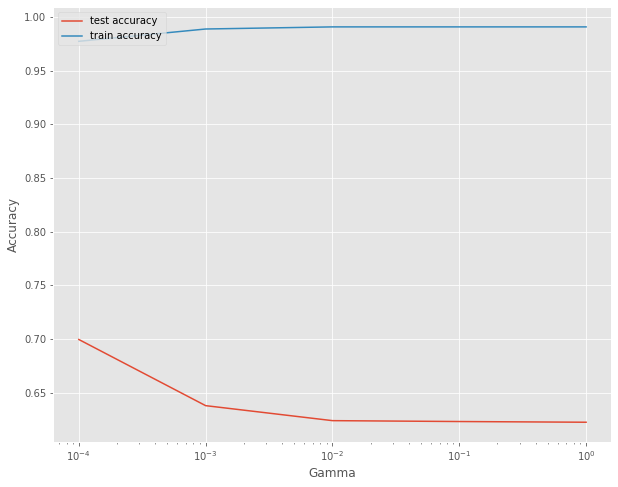

In [99]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_g['param_gamma'], cv_results_g['mean_test_score'])
plt.plot(cv_results_g['param_gamma'], cv_results_g['mean_train_score'])
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [100]:
print(model_cv_C.best_params_)
print(model_cv_g.best_params_)

{'C': 10}
{'gamma': 0.0001}


In [101]:
sv = SVC(C = 10 , gamma = 0.0001)
sv.fit(X_train , y_train)

y_pred_svm = sv.predict(X_test)

ac_svr = accuracy_score(y_test , y_pred_svm)
print(ac_svr*100)

76.49376231122784


In [153]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
auc_score=[]


for i in tqdm(alpha):
    model = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    model.fit(X_train, y_train)
    
    Cal_CV_model = CalibratedClassifierCV(model, method="sigmoid",cv=10)
    Cal_CV_model.fit(X_train, y_train)
    predict_y = Cal_CV_model.predict_proba(X_train)
    preds = predict_y[:,1]
    roc_auc = roc_auc_score(y_train, preds)
    auc_score.append(roc_auc)

100%|██████████| 9/9 [00:03<00:00,  2.72it/s]


In [154]:
# determining best value of alpha
optimal_alpha = alpha[auc_score.index(max(auc_score))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.010.


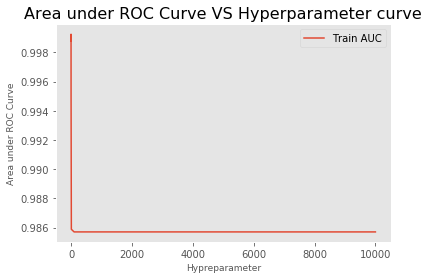

In [155]:
# plot accuracy vs alpha 
plt.plot(alpha, auc_score,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best alpha =  0.01
AUC =  74.40345041499101


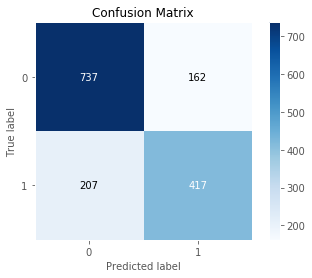

In [157]:
model = linear_model.SGDClassifier(alpha=optimal_alpha, loss='hinge', class_weight='balanced')
model.fit(X_train, y_train)

lr = CalibratedClassifierCV(model, method="sigmoid",cv=10)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best alpha = ",optimal_alpha)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

## Decision Tree on AVG-W2V

In [105]:
dt = DecisionTreeClassifier()
dt.fit(X_train , y_train)


y_pred_dt = dt.predict(X_test)

ac = accuracy_score(y_test , y_pred_dt)
print(ac*100)

73.27642810242942


In [84]:
n_folds = 5
parameters = {'min_samples_split': range(20 , 200 , 20)}

dtree = DecisionTreeClassifier(random_state = 100)

tree_split = GridSearchCV(dtree, parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_split.fit(X_train, y_train)


cv_results_ms = pd.DataFrame(tree_split.cv_results_)
cv_results_ms

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.391002,0.157445,0.001995,8.064048e-07,20,{'min_samples_split': 20},0.620690,0.583744,0.598522,0.595238,...,0.598194,0.012273,3,0.894704,0.891420,0.887315,0.895936,0.883621,0.890599,0.004593
1,1.193890,0.149641,0.001601,4.953851e-04,40,{'min_samples_split': 40},0.622332,0.600164,0.587028,0.580460,...,0.596223,0.014534,7,0.826765,0.824918,0.816708,0.834154,0.819376,0.824384,0.006090
2,1.025258,0.134781,0.001597,4.886558e-04,60,{'min_samples_split': 60},0.618227,0.614122,0.583744,0.576355,...,0.594089,0.018245,8,0.788383,0.785920,0.782635,0.783662,0.781404,0.784401,0.002482
3,0.943477,0.126330,0.001796,3.985886e-04,80,{'min_samples_split': 80},0.616585,0.602627,0.575534,0.592775,...,0.597537,0.013435,4,0.770115,0.757594,0.759236,0.750205,0.753489,0.758128,0.006775
4,0.995936,0.150644,0.001596,4.888309e-04,100,{'min_samples_split': 100},0.619869,0.600164,0.577176,0.596059,...,0.596388,0.014102,6,0.740969,0.731322,0.731732,0.741995,0.739327,0.737069,0.004606
5,0.858304,0.132267,0.002195,9.773393e-04,120,{'min_samples_split': 120},0.616585,0.598522,0.574713,0.601806,...,0.597209,0.013507,5,0.723522,0.729680,0.717980,0.737274,0.725369,0.726765,0.006459
6,0.851721,0.150946,0.003592,2.720544e-03,140,{'min_samples_split': 140},0.610837,0.588670,0.573892,0.600985,...,0.592939,0.012434,9,0.717980,0.714696,0.707512,0.726396,0.713670,0.716051,0.006183
7,0.817810,0.145943,0.001599,4.864952e-04,160,{'min_samples_split': 160},0.614122,0.605090,0.573892,0.601806,...,0.598522,0.013451,2,0.709565,0.696018,0.704433,0.723522,0.707307,0.708169,0.008944
8,0.808983,0.135011,0.000799,9.787909e-04,180,{'min_samples_split': 180},0.610837,0.609195,0.579639,0.607553,...,0.600657,0.011722,1,0.698276,0.690271,0.700123,0.710591,0.703612,0.700575,0.006652


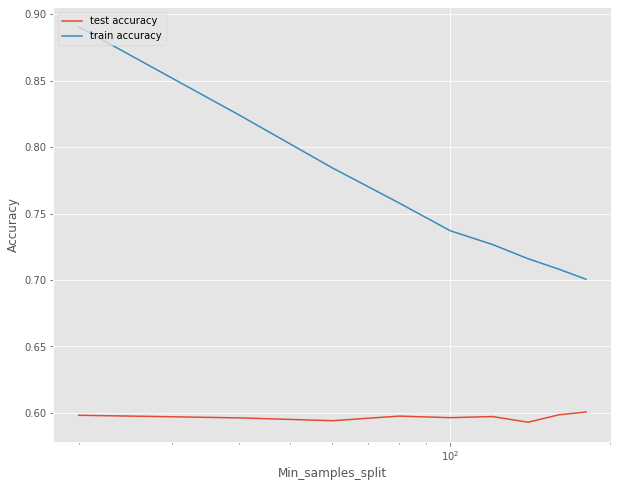

In [85]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_ms['param_min_samples_split'] , cv_results_ms['mean_test_score'])
plt.plot(cv_results_ms['param_min_samples_split'] , cv_results_ms['mean_train_score'])
plt.xlabel('Min_samples_split')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [86]:
n_folds = 5
parameters = {'min_samples_leaf': range (1 , 20)}

dtree = DecisionTreeClassifier()

tree_ml = GridSearchCV(dtree , parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_ml.fit(X_train, y_train)


cv_results_ml = pd.DataFrame(tree_ml.cv_results_)
cv_results_ml

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.179246,0.173321,0.001995,1.118282e-06,1,{'min_samples_leaf': 1},0.620690,0.608374,0.599343,0.597701,...,0.601314,0.013245,17,0.984401,0.984811,0.983580,0.983990,0.985016,0.984360,0.000526
1,1.258433,0.248483,0.003988,3.989841e-03,2,{'min_samples_leaf': 2},0.623974,0.603448,0.604269,0.598522,...,0.604762,0.010341,7,0.957307,0.956486,0.950328,0.955255,0.952997,0.954475,0.002532
2,1.028649,0.126094,0.001796,3.991130e-04,3,{'min_samples_leaf': 3},0.611658,0.605090,0.595238,0.600985,...,0.598851,0.010289,18,0.942118,0.938013,0.934934,0.937808,0.935550,0.937685,0.002526
3,1.054976,0.148076,0.002394,1.352417e-03,4,{'min_samples_leaf': 4},0.616585,0.605090,0.602627,0.607553,...,0.603448,0.010189,12,0.918514,0.917282,0.914409,0.911946,0.913588,0.915148,0.002413
4,1.032487,0.134160,0.001796,3.986125e-04,5,{'min_samples_leaf': 5},0.615764,0.590312,0.573892,0.605911,...,0.595731,0.014283,19,0.903325,0.897373,0.897989,0.901067,0.898194,0.899589,0.002261
5,0.989952,0.132072,0.002194,3.986604e-04,6,{'min_samples_leaf': 6},0.618227,0.600985,0.574713,0.605911,...,0.601478,0.014517,16,0.886494,0.878900,0.881158,0.882389,0.882594,0.882307,0.002472
6,0.983170,0.140204,0.002794,1.595879e-03,7,{'min_samples_leaf': 7},0.616585,0.609195,0.587028,0.601806,...,0.603448,0.009784,11,0.872537,0.861864,0.869869,0.869253,0.868227,0.868350,0.003542
7,1.052984,0.161772,0.001799,4.007924e-04,8,{'min_samples_leaf': 8},0.609195,0.619869,0.599343,0.588670,...,0.603612,0.010429,10,0.863095,0.852627,0.852627,0.855090,0.854680,0.855624,0.003872
8,1.164938,0.193322,0.005187,6.892843e-03,9,{'min_samples_leaf': 9},0.618227,0.610016,0.603448,0.601806,...,0.605255,0.008507,6,0.852011,0.843186,0.838465,0.842159,0.842159,0.843596,0.004504
9,1.184430,0.166934,0.001795,1.162516e-03,10,{'min_samples_leaf': 10},0.614122,0.603448,0.591954,0.613300,...,0.602627,0.010122,13,0.839696,0.828407,0.827176,0.830665,0.830255,0.831240,0.004413


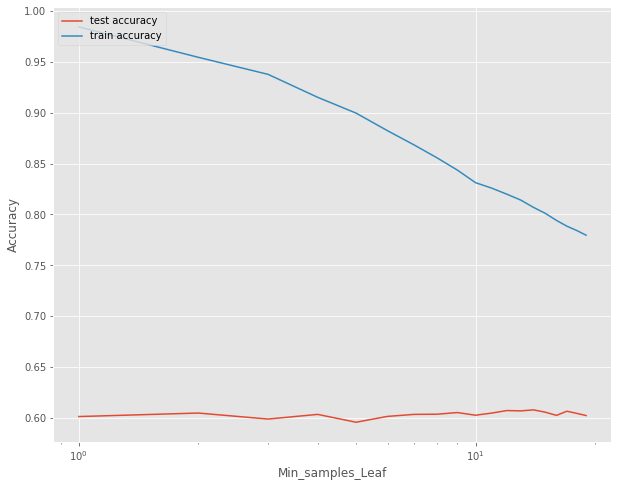

In [87]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_ml['param_min_samples_leaf'] , cv_results_ml['mean_test_score'])
plt.plot(cv_results_ml['param_min_samples_leaf'] , cv_results_ml['mean_train_score'])
plt.xlabel('Min_samples_Leaf')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [117]:
n_folds = 5
parameters = {'max_depth':range (1,20)}

dtree = DecisionTreeClassifier()

tree_d = GridSearchCV(dtree , parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_d.fit(X_train, y_train)


cv_results_d = pd.DataFrame(tree_d.cv_results_)
cv_results_d

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.170145,0.015624,0.001197,0.000747,1,{'max_depth': 1},0.614943,0.565681,0.598522,0.595238,...,0.591790,0.016292,19,0.598933,0.565271,0.603038,0.603859,0.606527,0.595525,0.015322
1,0.170552,0.008231,0.000999,0.000894,2,{'max_depth': 2},0.630542,0.624795,0.607553,0.605911,...,0.615271,0.010302,18,0.617816,0.608580,0.623974,0.612479,0.625205,0.617611,0.006420
2,0.173044,0.014575,0.000599,0.000798,3,{'max_depth': 3},0.644499,0.640394,0.616585,0.609195,...,0.626601,0.013654,17,0.634852,0.626026,0.635263,0.621100,0.642241,0.631897,0.007458
3,0.243511,0.011576,0.001397,0.000488,4,{'max_depth': 4},0.642857,0.648604,0.636289,0.623153,...,0.636125,0.009060,16,0.637521,0.637931,0.650452,0.634031,0.654351,0.642857,0.008005
4,0.263797,0.020012,0.003591,0.004306,5,{'max_depth': 5},0.642857,0.653530,0.637931,0.636289,...,0.639737,0.008379,15,0.651683,0.651683,0.652915,0.644704,0.659893,0.652176,0.004825
5,0.276311,0.032506,0.001197,0.000978,6,{'max_depth': 6},0.653530,0.659278,0.648604,0.646141,...,0.647126,0.010532,14,0.662356,0.664614,0.667488,0.656404,0.662151,0.662603,0.003650
6,0.261819,0.029855,0.000598,0.000798,7,{'max_depth': 7},0.647783,0.661741,0.642857,0.655993,...,0.651232,0.006738,13,0.666872,0.669130,0.671798,0.670977,0.678161,0.671388,0.003787
7,0.301386,0.039834,0.001806,0.003136,8,{'max_depth': 8},0.645320,0.664204,0.645320,0.669951,...,0.654351,0.010565,12,0.675082,0.682061,0.685755,0.685755,0.689245,0.683580,0.004818
8,0.306118,0.010263,0.002604,0.002740,9,{'max_depth': 9},0.648604,0.665025,0.650246,0.671593,...,0.657471,0.009148,11,0.682471,0.693760,0.694171,0.698892,0.702586,0.694376,0.006781
9,0.356868,0.018729,0.001596,0.000798,10,{'max_depth': 10},0.649425,0.670772,0.651067,0.663383,...,0.658128,0.007970,10,0.691092,0.702381,0.703407,0.710796,0.711823,0.703900,0.007442


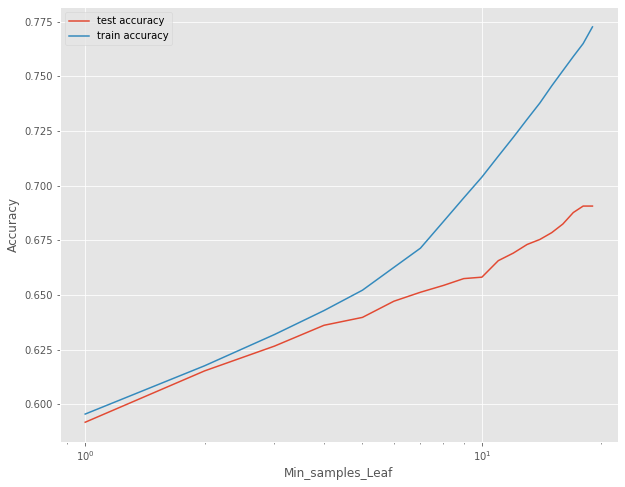

In [130]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_d['param_max_depth'] , cv_results_d['mean_test_score'])
plt.plot(cv_results_d['param_max_depth'] , cv_results_d['mean_train_score'])
plt.xlabel('Min_samples_Leaf')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [122]:
print(tree_split.best_params_)
print(tree_ml.best_params_)
print(tree_d.best_params_)

{'min_samples_leaf': 5}
{'min_samples_leaf': 1}
{'max_depth': 18}


In [89]:
dt = DecisionTreeClassifier(max_depth = 18 , min_samples_leaf = 1 , min_samples_split = 5)
dt.fit(X_train , y_train)


y_pred_dt = dt.predict(X_test)

ac = accuracy_score(y_test , y_pred_dt)
print(ac*100)

60.99803020354564


***Test Data Report***
Best max_depth =  20
Best min_samples_split =  80
AUC =  75.35072801688486


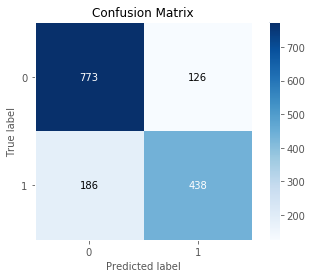

In [148]:
optimal_depth = 20
optimal_split = 80

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best min_samples_split = ",optimal_split)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

## Random Forest on AVG-W2V

In [90]:
max_depths = [2,4,6,9,11]
base_learners = [1, 5, 10, 50, 100]
param_grid = {'max_depth': max_depths,'n_estimators':base_learners}


model = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1 , return_train_score = True)
model.fit(X_train, y_train)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

Model with best parameters :
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy of the model :  0.9867271197694089


In [91]:
y_pred_rf = model.predict(X_test)
ac = accuracy_score(y_test , y_pred_rf)
ac

0.6684175968483257

In [160]:
dataframe = pd.DataFrame(model.cv_results_)
dataframe.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.016784,0.003406,0.000675,0.000955,2,1,"{'max_depth': 2, 'n_estimators': 1}",0.514654,0.514991,0.510731,0.513459,0.001934,25,0.509267,0.510548,0.508563,0.509459,0.000822
1,0.043731,0.009535,0.012799,0.005317,2,5,"{'max_depth': 2, 'n_estimators': 5}",0.565285,0.554500,0.560647,0.560144,0.004417,20,0.568298,0.571047,0.550917,0.563421,0.008912
2,0.074657,0.012385,0.009410,0.000942,2,10,"{'max_depth': 2, 'n_estimators': 10}",0.565513,0.560969,0.581568,0.569350,0.008836,19,0.575417,0.575861,0.588435,0.579904,0.006035
3,0.287726,0.008659,0.035086,0.006827,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.750251,0.740355,0.724296,0.738301,0.010695,10,0.780679,0.772175,0.743233,0.765362,0.016028
4,0.587622,0.009146,0.065997,0.007233,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.776570,0.750898,0.775343,0.767604,0.011823,9,0.802325,0.806335,0.808256,0.805639,0.002471


C:\Users\Mahmudur Limon\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



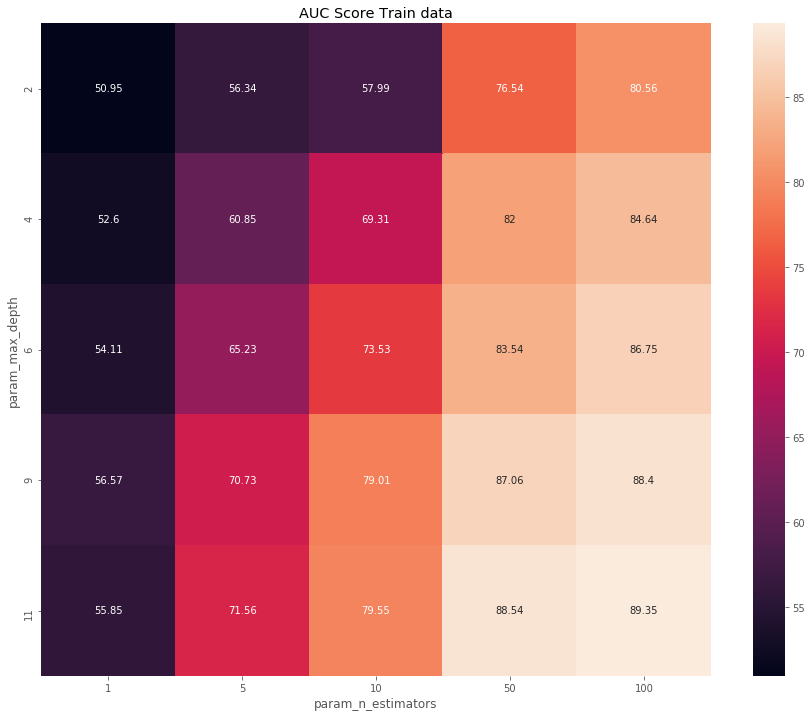

In [166]:
# Train Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize = (15 , 12))
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('AUC Score Train data')
plt.show()

C:\Users\Mahmudur Limon\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



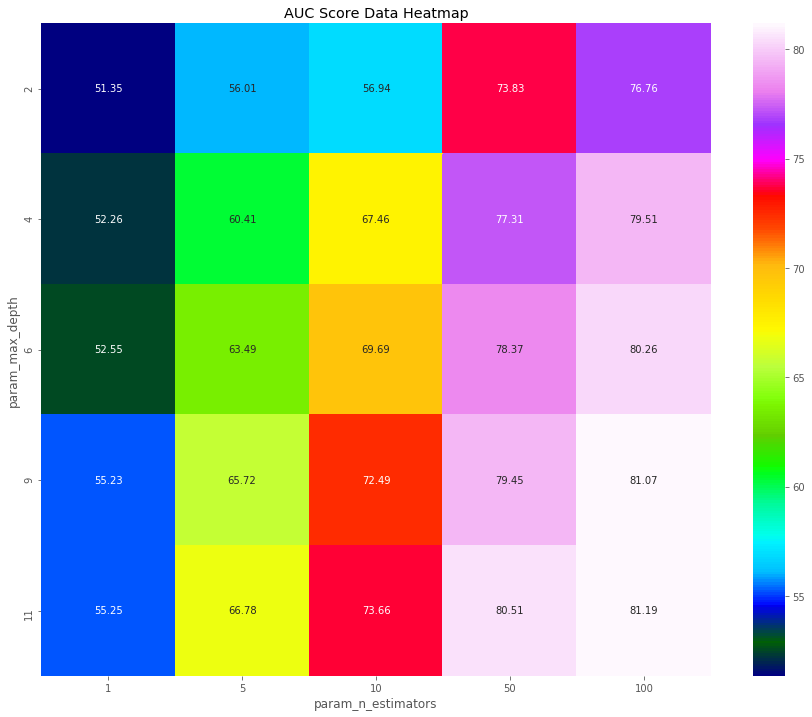

In [165]:
# CV Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize = (15 , 12))
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g' , cmap = 'gist_ncar')
ax = plt.axes()
ax.set_title('AUC Score Data Heatmap')
plt.show()

***Test Data Report***
Best max_depth =  11
Best Base Learners =  100
AUC =  74.05646587376287


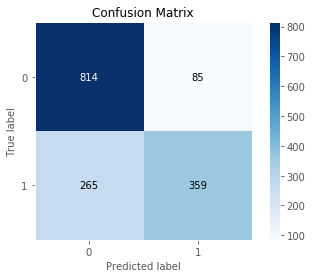

In [169]:
optimal_depth = 11
optimal_estimators = 100

lr = RandomForestClassifier(n_estimators=optimal_estimators, max_depth=optimal_depth, class_weight='balanced')
lr.fit(X_train_BOW,y_train)
pred = lr.predict(X_test_BOW)

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best Base Learners = ",optimal_estimators)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [221]:
rf = RandomForestClassifier()
rf.fit(X_train , y_train)

y_pred_rf = rf.predict(X_test)

ac_rf = accuracy_score(y_test , y_pred_rf)
print(ac_rf*100)

80.56467498358502


In [228]:
test_pred = rf.predict(test_BOW)

In [229]:
# test_pred = rf.predict(test_BOW)
# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission02.csv', index=False)

In [174]:
n_folds = 10
parameters = {'max_depth': range(2, 30, 2)}

rf = RandomForestClassifier(random_state = 100)
grd_search_max = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)

grd_search_max.fit(X_train , y_train)
print('Best parameter for max_depth: ',grd_search_max.best_params_)

scores = grd_search_max.cv_results_
pd.DataFrame(scores).head()

Best parameter for max_depth:  {'max_depth': 28}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.097105,0.101208,0.054257,0.011452,2,{'max_depth': 2},0.566502,0.568144,0.569787,0.569787,...,0.568144,0.571976,0.565408,0.569057,0.565408,0.565408,0.565408,0.565955,0.566940,0.002117
1,1.320912,0.090097,0.050891,0.016362,4,{'max_depth': 4},0.581281,0.587849,0.586207,0.582923,...,0.591498,0.587484,0.588579,0.586572,0.583653,0.593870,0.587302,0.582375,0.587210,0.003518
2,1.509562,0.060344,0.037270,0.007206,6,{'max_depth': 6},0.610837,0.604269,0.604269,0.612479,...,0.617223,0.612479,0.613392,0.613574,0.604269,0.611020,0.611932,0.615399,0.612425,0.003527
3,1.859384,0.052908,0.034113,0.005775,8,{'max_depth': 8},0.635468,0.620690,0.619048,0.630542,...,0.632184,0.634921,0.635833,0.634373,0.627440,0.630724,0.635103,0.635833,0.633060,0.002836
4,2.560092,0.079024,0.051421,0.013828,10,{'max_depth': 10},0.658456,0.645320,0.632184,0.645320,...,0.652801,0.651706,0.651888,0.654260,0.653348,0.650064,0.650064,0.651523,0.652563,0.001917


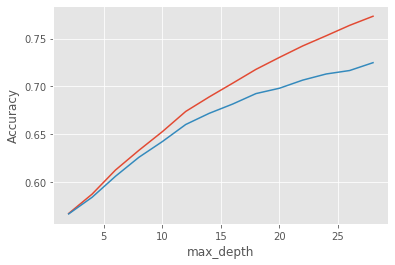

In [175]:
plt.figure()
plt.plot(scores["param_max_depth"],scores["mean_train_score"],label="Training accuracy")
plt.plot(scores["param_max_depth"],scores["mean_test_score"],label="Test accuracy")
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()


In [177]:
n_folds = 5
parameters = {'n_estimators': range(50, 500, 50)}

rf = RandomForestClassifier(random_state = 100)
grd_search_est = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)

grd_search_est.fit(X_train, y_train)
print('Best parameter for n_estimators: ',grd_search_est.best_params_)

scores_1 = grd_search_est.cv_results_
pd.DataFrame(scores_1).head()

Best parameter for n_estimators:  {'n_estimators': 350}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,16.495535,0.501997,0.091412,0.012973,50,{'n_estimators': 50},0.793103,0.786535,0.781609,0.770115,...,0.782102,0.007660,8,0.989943,0.991379,0.988711,0.989943,0.989122,0.989819,0.000914
1,34.319227,1.058878,0.229507,0.038290,100,{'n_estimators': 100},0.786535,0.783251,0.782430,0.770936,...,0.780460,0.005311,9,0.990969,0.991995,0.989327,0.990558,0.989943,0.990558,0.000909
2,50.603185,0.384209,0.289535,0.035433,150,{'n_estimators': 150},0.793103,0.791461,0.784893,0.777504,...,0.784072,0.007667,7,0.990969,0.991995,0.989532,0.990558,0.989943,0.990599,0.000855
3,66.416147,2.983965,0.445283,0.053172,200,{'n_estimators': 200},0.793103,0.791461,0.784072,0.777504,...,0.785222,0.006157,4,0.990969,0.991995,0.989532,0.990558,0.989943,0.990599,0.000855
4,71.182656,8.838264,0.355182,0.004933,250,{'n_estimators': 250},0.792282,0.790640,0.782430,0.776683,...,0.784401,0.006069,6,0.990969,0.991995,0.989532,0.990558,0.989943,0.990599,0.000855


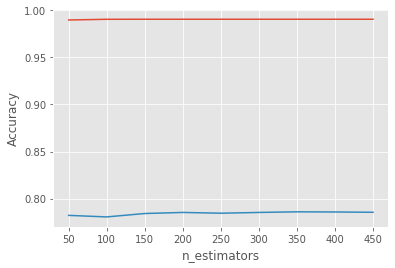

In [178]:
plt.figure()
plt.plot(scores_1["param_n_estimators"],scores_1["mean_train_score"],label="Training accuracy")
plt.plot(scores_1["param_n_estimators"],scores_1["mean_test_score"],label="Test accuracy")
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()

In [179]:
n_folds = 5
parameters = {'min_samples_leaf': range(30, 400, 50)}

rf = RandomForestClassifier(random_state = 100)
grd_search_lf = GridSearchCV(rf , parameters , cv = n_folds , return_train_score = True)

grd_search_lf.fit(X_train, y_train)
print('Best parameter for min_samples_leaf: ',grd_search_lf.best_params_)

scores_2 = grd_search_lf.cv_results_
pd.DataFrame(scores_2).head()

Best parameter for min_samples_leaf:  {'min_samples_leaf': 30}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.286695,0.315587,0.101946,0.083947,30,{'min_samples_leaf': 30},0.565681,0.565681,0.565681,0.56486,...,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
1,0.847230,0.133691,0.088366,0.043182,80,{'min_samples_leaf': 80},0.565681,0.565681,0.565681,0.56486,...,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
2,0.556950,0.024576,0.045469,0.006044,130,{'min_samples_leaf': 130},0.565681,0.565681,0.565681,0.56486,...,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
3,0.666235,0.397856,0.044280,0.015913,180,{'min_samples_leaf': 180},0.565681,0.565681,0.565681,0.56486,...,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
4,0.697134,0.398707,0.046674,0.034540,230,{'min_samples_leaf': 230},0.565681,0.565681,0.565681,0.56486,...,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101


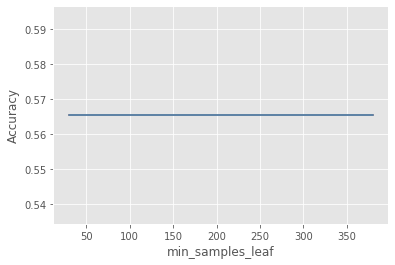

In [180]:
plt.figure()
plt.plot(scores_2["param_min_samples_leaf"],scores_2["mean_train_score"],label="Training accuracy")
plt.plot(scores_2["param_min_samples_leaf"],scores_2["mean_test_score"],label="Test accuracy")
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.show()

In [184]:
n_folds = 5
parameters = {'min_samples_split': range(10, 400, 50)}

rf = RandomForestClassifier()
grd_search_sp = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1, return_train_score = True)

grd_search_sp.fit(X_train, y_train)
print('Best parameter for min_samples_split: ',grd_search_sp.best_params_)

score_3 = grd_search_sp.cv_results_
pd.DataFrame(score_3).head()

Best parameter for min_samples_split:  {'min_samples_split': 160}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,21.406171,0.767308,0.187100,0.008430,10,{'min_samples_split': 10},0.792282,0.795567,0.787356,0.785714,...,0.788834,0.004479,2,0.975575,0.975780,0.974343,0.974754,0.975780,0.975246,0.000589
1,17.413395,0.232521,0.172140,0.007559,60,{'min_samples_split': 60},0.797209,0.789819,0.774220,0.784893,...,0.787849,0.007919,5,0.952176,0.950328,0.950534,0.954639,0.952997,0.952135,0.001603
2,16.887572,0.341539,0.183394,0.032281,110,{'min_samples_split': 110},0.784893,0.786535,0.784893,0.784072,...,0.786371,0.002668,8,0.934524,0.935961,0.937397,0.936987,0.937808,0.936535,0.001178
3,17.409879,0.796128,0.159774,0.019540,160,{'min_samples_split': 160},0.798030,0.791461,0.788177,0.792282,...,0.792118,0.003259,1,0.923440,0.925082,0.927340,0.930419,0.923645,0.925985,0.002618
4,17.294000,0.458271,0.152191,0.012641,210,{'min_samples_split': 210},0.790640,0.788998,0.773399,0.790640,...,0.788342,0.008101,3,0.920567,0.918719,0.919335,0.922824,0.915640,0.919417,0.002353


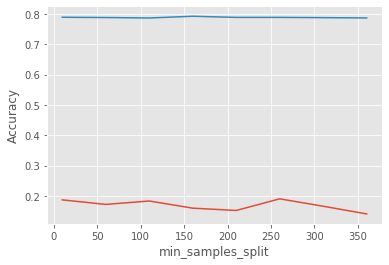

In [185]:
plt.figure()
plt.plot(score_3["param_min_samples_split"],score_3["mean_score_time"],label="Training accuracy")
plt.plot(score_3["param_min_samples_split"],score_3["mean_test_score"],label="Test accuracy")
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.show()

In [186]:
print('Best parameter for max_depth: ',grd_search_max.best_params_)
print('Best parameter for min_samples_leaf: ',grd_search_lf.best_params_)
print('Best parameter for min_samples_split: ',grd_search_sp.best_params_)
print('Best parameter for n_estimators: ',grd_search_est.best_params_)

Best parameter for max_depth:  {'max_depth': 28}
Best parameter for min_samples_leaf:  {'min_samples_leaf': 30}
Best parameter for min_samples_split:  {'min_samples_split': 160}
Best parameter for n_estimators:  {'n_estimators': 350}


In [194]:
new_rf = RandomForestClassifier(n_estimators = 350 , max_depth = 28 , min_samples_leaf = 30 , min_samples_split = 160)
new_rf.fit(X_train , y_train)

y_pred_rf = new_rf.predict(X_test)

ac_rf = accuracy_score(y_test , y_pred_rf)
print(ac_rf*100)

59.02823374917925


## GBDT on AVG-W2V

In [196]:
learn_rate = {'learning_rate': [0.001 , 0.01 , 0.1 , 1.0 , 1.3]}
folds = 5

In [200]:
GBC = GradientBoostingClassifier()

grd_search_lr = GridSearchCV(GBC , cv = folds , param_grid = learn_rate , n_jobs = -1)
grd_search_lr.fit(X_train, y_train)
print('Best parameter for max_depth: ' , grd_search_lr.best_params_)

cv_results_gbdt = pd.DataFrame(grd_search_lr.cv_results_)
cv_results_gbdt.head()

Best parameter for max_depth:  {'learning_rate': 1.0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,20.821945,0.444296,0.005187,0.000746,0.001,{'learning_rate': 0.001},0.565681,0.565681,0.565681,0.564860,0.564860,0.565353,0.000402,5
1,19.947538,0.141624,0.008776,0.002555,0.01,{'learning_rate': 0.01},0.677340,0.669951,0.639573,0.653530,0.635468,0.655172,0.016396,4
2,19.750963,0.283580,0.006586,0.001736,0.1,{'learning_rate': 0.1},0.744663,0.725780,0.738095,0.734811,0.747126,0.738095,0.007578,3
3,21.138318,0.932057,0.006097,0.000482,1,{'learning_rate': 1.0},0.759442,0.773399,0.757800,0.768473,0.775041,0.766831,0.007063,1
4,18.426071,2.278891,0.004915,0.001023,1.3,{'learning_rate': 1.3},0.763547,0.756158,0.738916,0.756158,0.766010,0.756158,0.009476,2


In [203]:
sub_sample = {"subsample": [0.3, 0.6, 0.9]}
folds = 5

In [204]:
GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200)

grd_search_ss = GridSearchCV(GBC , cv = folds , param_grid = sub_sample)
grd_search_ss.fit(X_train, y_train)
print('Best parameter for max_depth: ',grd_search_ss.best_params_)

cv_results_sub = pd.DataFrame(grd_search_lr.cv_results_)
cv_results_sub.head()

Best parameter for max_depth:  {'subsample': 0.6}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,20.821945,0.444296,0.005187,0.000746,0.001,{'learning_rate': 0.001},0.565681,0.565681,0.565681,0.564860,0.564860,0.565353,0.000402,5
1,19.947538,0.141624,0.008776,0.002555,0.01,{'learning_rate': 0.01},0.677340,0.669951,0.639573,0.653530,0.635468,0.655172,0.016396,4
2,19.750963,0.283580,0.006586,0.001736,0.1,{'learning_rate': 0.1},0.744663,0.725780,0.738095,0.734811,0.747126,0.738095,0.007578,3
3,21.138318,0.932057,0.006097,0.000482,1,{'learning_rate': 1.0},0.759442,0.773399,0.757800,0.768473,0.775041,0.766831,0.007063,1
4,18.426071,2.278891,0.004915,0.001023,1.3,{'learning_rate': 1.3},0.763547,0.756158,0.738916,0.756158,0.766010,0.756158,0.009476,2


In [106]:
#GBC = GradientBoostingClassifier(subsample = 0.6 , learning_rate = 0.1 , n_estimators=50 , max_features = 8 , min_samples_leaf = 30 , min_samples_split = 10)

GBC = GradientBoostingClassifier(subsample = 0.6 , learning_rate = 1.0 ,  n_estimators=150)
GBC.fit(X_train , y_train)

y_gbr = GBC.predict(X_test)

ac_gbr = accuracy_score(y_test , y_gbr)
print(ac_gbr*100)

61.457649376231124


## XGB on AVG-W2V

In [105]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

ac_xg = accuracy_score(y_test , y_pred)
print(ac_xg*100)

66.71043992120815


In [138]:
max_depths = [2,4,6,9,11]
base_learners = [1, 5, 10, 50, 100]
param_grid = {'max_depth': max_depths,'n_estimators':base_learners}

model = GridSearchCV(xgb.XGBClassifier(scale_pos_weight=1), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1 , return_train_score = True) 
model.fit(X_train, y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

Model with best parameters :
 XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
Accuracy of the model :  0.993570722328699


***Test Data Report***
Best max_depth =  9
Best Base Learners =  100
AUC =  50.96724280539631


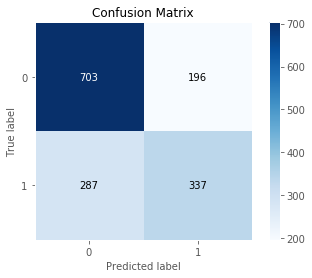

In [107]:
optimal_depth = 9
optimal_estimators = 100


xg_model = xgb.XGBClassifier(max_depth=optimal_depth, n_estimators=optimal_estimators, scale_pos_weight=1)
xg_model.fit(X_train,y_train)

pred = xg_model.predict(X_test)

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best Base Learners = ",optimal_estimators)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [230]:
# test_pred = xg_model.predict(test_BOW)

# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission02xgb.csv', index=False)